## Import the librairies for the processing

In [27]:
%run librairiesCNN.py

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


Fix random seed to make sure we get reproducible results.

In [28]:
my_seed = 12345
random.seed(my_seed)
np.random.seed(my_seed)

## Set parameters for the DNS test

Specify the maximum discplacement, particle sizes and particle density per interrogation window to be used for the synthetic image.
Choose the final size of the synthetic image, it will rescale the DNS by cropping or interpolating.

In [29]:
width=1024
height=1024
maxDisplacement=24# in px
particleRadius=range(2,4) #for each particle
gaussianBlurRadius=1
particleDensity=range(2,10) #per image

############################ SAVING DATA ####################################################
#If you want to save the images, set recordImage=True and specify the location and name 
#of the saved files. Make sure the directory DATASETfromDNS exist 
saveImage=False
folder='data/'
imageFile='dataset_JN'

## Load convolutional networks and setup an ensemble 

In [30]:
from CNN_architectures import StreaksCNN

file_net = 'networks/network_grayscale_gradient_uniformDisp_n=1M'
h5f = h5py.File(('%s_data.h5' % file_net), 'r')

testImages = h5f['validationImages'][()]
testData = h5f['validationData'][()]
scale = h5f['scale'][()]
mean = h5f['mean'][()]
windowSize = h5f['windowSize'][()]
n_ensemble_members = h5f['n_ensemble_members'][()]
filter_size = h5f['filter_size'][()]
padding = h5f['padding'][()]
h5f.close()

net_ensemble = []
for n in range(n_ensemble_members):
    f_output_name = '%s_%d.pytorch' % (file_net, n)
    net_ensemble.append(StreaksCNN(winSz = windowSize, \
                                   filtSz = filter_size, \
                                   convPad = padding))
    
    net_ensemble[n].load_state_dict(torch.load('%s_%d.pytorch' % (file_net, n), map_location = device))
    net_ensemble[n].to(device)
    net_ensemble[n].eval()
    
scaler = StandardScaler()
scaler.mean_ = mean
scaler.scale_ = scale

CNN_width=windowSize
CNN_height=windowSize
overlap=24

## Load DNS

In [31]:
fileName='./data/dataSetFromDNS_EPM.hdf5'
f=h5py.File(fileName,'r')

# store data in array
_x00=f[('x')][:]
_y00=f[('y')][:]
u00=f[('u')][:]
v00=f[('v')][:]
# rescaling DNS to the user defined max displacement
u00=u00/u00.max()*maxDisplacement
v00=v00/v00.max()*maxDisplacement

f.close()

originalDisplacement=np.sqrt(u00**2+v00**2)

print('Upload data from {}'.format(fileName))
print('Original Shape of X {}'.format(_x00.shape[0]))
print('Original Shape of Y {}'.format(_y00.shape[0]))
print('Original Shape of U,V {}'.format(u00.shape))

#if the desired image size is different from the original data set, we crop or interpolate
if (_x00.shape[0]!=width) or (_y00.shape[0]!=height):
    resizeImage=True
    _x=np.arange(width)
    _y=np.arange(height)
    u=np.array(skimage.transform.resize(u00, (height, width), anti_aliasing=True))
    v=np.array(skimage.transform.resize(v00, (height, width), anti_aliasing=True))
else:
    resizeImage=False
    _x=_x00
    _y=_y00
    u,v=u00,v00

Upload data from ./data/dataSetFromDNS_EPM.hdf5
Original Shape of X 192
Original Shape of Y 192
Original Shape of U,V (192, 192)


## Calculate the mean displacement, angle and energy spectrum

In [32]:
x,y=np.meshgrid(_x,_y)
displacement=np.sqrt(u**2+v**2)
angle=np.arctan(v/u)*180/np.pi
energy=np.mean(displacement)**2
kx,Ekx,ky,Eky,k,Ek,Ek2D = getEnergySpectrum(_x,_y,displacement-displacement.mean())

originalWidth=_x00.shape[0]
originalheight=_y00.shape[0]
resizedWidth=_x.shape[0]
resizedHeight=_y.shape[0]

print('resizing image')
print('Resized X {}'.format(resizedWidth))
print('Resized Y {}'.format(resizedHeight))
print('Resized U,V {}'.format(u.shape))

xdns,ydns,displacementdns,angledns,W,H=windowAveraging(displacement,angle,CNN_width,CNN_height,overlap)

resizing image
Resized X 1024
Resized Y 1024
Resized U,V (1024, 1024)


Plot DNS and its statistics

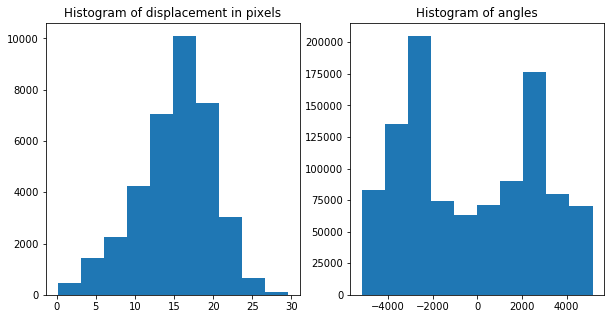

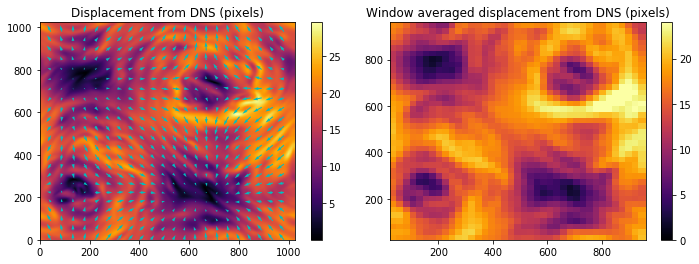

In [33]:
fig = figure(figsize=(10,5))
fig.add_subplot(1,2,1)
title('Histogram of displacement in pixels')
hist(originalDisplacement.flatten())   
fig.add_subplot(1,2,2)
title('Histogram of angles')
hist(angle.flatten()*180/np.pi)
show()

width = height = 23
x_vec = np.arange(width, dtype='float') * resizedWidth / width
y_vec = np.arange(height, dtype='float') * resizedWidth / width
U_vec = np.array(skimage.transform.resize(u00, (height, width), anti_aliasing=True))
V_vec = np.array(skimage.transform.resize(v00, (height, width), anti_aliasing=True))
x_grid, y_grid = np.meshgrid(x_vec, y_vec)

fig = figure(figsize=(12,4))
fig.add_subplot(1,2,1)
title('Displacement from DNS (pixels)')
p = pcolormesh(x,y,displacement,cmap='inferno')
quiver(x_grid, y_grid, U_vec, V_vec, color = 'c', width = 0.004)
colorbar(p)
fig.add_subplot(1,2,2)
title('Window averaged displacement from DNS (pixels)')
pmean = pcolormesh(xdns,ydns,displacementdns,vmin=0,vmax=maxDisplacement,cmap='inferno')
colorbar(pmean)

subplots_adjust(hspace=0.35, wspace = 0.1)
savefig('paper/figs/figure5.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)
show()

## Generate streak images from DNS

Finished, took 18.0686s. 1.66 images/sec.


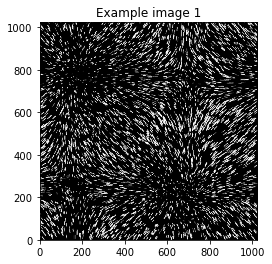

In [34]:
# Generate count images
nImages = 30
start_time = time.time()
myImagesGenerator = DNS_StreakImageGenerator(x,y,u,v,particleDensity,particleRadius,CNN_width,CNN_height)
myImages= myImagesGenerator.generate(count = nImages, sigma = 1, truncate = 2)
elapsed_time = time.time() - start_time
print("Finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
        nImages / elapsed_time))
     
# Plot one of images
iImage = 1
figure()
title('Example image %d' % iImage)
gray()
imshow(myImages[iImage,0,:,:], origin='lower')

im = Image.fromarray(myImages[iImage,0,:,:])

# Save images in an HDF5 file
if saveImage:
    fileName = folder + imageFile + '.hdf5'
    h = h5py.File(fileName,'w')
    h.create_dataset('x',data=x)
    h.create_dataset('y',data=y)
    h.create_dataset('u',data=u)
    h.create_dataset('v',data=v)
    h.create_dataset('images',data=myImages)
    h.close()

## Apply the CNN ensemble to the batch of synthetic images

In [35]:
# Apply the N networks to the image , 
applyEnsemble = True 
# Otherwise apply the n-th network only
cnnIndex = 3 

_xcnnConcatenated,_ycnnConcatenated,splittedImages,nh,nw =\
splitWindows(myImages,CNN_width,CNN_height,overlap)

start_time=time.time()

predictionEnsemble=np.zeros((n_ensemble_members,splittedImages.shape[1],2))
predictionSingle=np.zeros((splittedImages.shape[0],splittedImages.shape[1],2))
prediction=np.zeros((splittedImages.shape[0],splittedImages.shape[1],2))
displacementcnn=np.zeros((splittedImages.shape[0],nh,nw))
anglecnn=np.zeros((splittedImages.shape[0],nh,nw))

print('Processing with Ensemble image:', end=' ')
for iImage in range(nImages):  
    imagesTOprocess = splittedImages[iImage,:,:,:,:]
    inputs = torch.from_numpy(np.array(imagesTOprocess) / 255).type(torch.FloatTensor)
    inputs = inputs.to(device)
    
    if applyEnsemble:
        print(iImage, end=', ')
        for n in range(n_ensemble_members):
            net = net_ensemble[n]
            net.eval()
            net_outputs = net(inputs) 
            if 'cuda' in device.type:
                net_outputs = net_outputs.cpu()

            predictionEnsemble[n,:,:] = scaler.inverse_transform(net_outputs.data.numpy())
            prediction[iImage,:,:] += predictionEnsemble[n,:,:]

        prediction /= n_ensemble_members
    
    else:    
        print(iImage, end=', ')
        net = net_ensemble[cnnIndex]
        net.eval()
        # Forward pass
        net_outputs = net(inputs)
        if 'cuda' in device.type:
            net_outputs = net_outputs.cpu()

        prediction[iImage,:,:] = scaler.inverse_transform(net_outputs.data.numpy())

    displacementcnn[iImage,:,:] = np.reshape(prediction[iImage,:,0], (nh,nw))
    anglecnn[iImage,:,:] = np.reshape(prediction[iImage,:,1], (nh,nw))
    xcnn = np.reshape(np.array(_xcnnConcatenated), (nh,nw))
    ycnn = np.reshape(np.array(_ycnnConcatenated), (nh,nw))
    _xcnn = xcnn[:,0]
    _ycnn = ycnn[0,:]

elapsed_time = time.time() - start_time
print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                            nImages / elapsed_time))

Processing with Ensemble image: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, Testing finished, took 79.8855s. 0.38 images/sec.


## Apply probabilistic Hough transform to the DNS

In [43]:
start_time=time.time()

Delta_residuals=[]
Angle_residuals=[]
predictionDelta=[]
predictionAngle=[]
rmsDelta=[]
rmsAngle=[]

DeltaDNS=np.concatenate(displacementdns)
AngleDNS=np.concatenate(angledns)

displacementHough=np.zeros((nh,nw))
angleHough=np.zeros((nh,nw))

numberEmptyLines=0
imagesTOprocess = splittedImages[iImage,:,:,:,:]
for i in range(imagesTOprocess.shape[0]):
    lines,displacements,angles,Delta,Angle,rmsD,rmsA=probHoughTransform(\
             imagesTOprocess[i,0,:,:],\
             threshold=10, \
             line_length=3,\
             line_gap=5)

    if len(lines)==0:
        numberEmptyLines+=1
        predictionDelta.append(np.nan)
        predictionAngle.append(np.nan)
        rmsDelta.append(np.nan)
        rmsAngle.append(np.nan)
        Delta_residuals.append(np.nan)
        Angle_residuals.append(np.nan)
    else:    
        predictionDelta.append(Delta)
        predictionAngle.append(Angle)
        rmsDelta.append(rmsD)
        rmsAngle.append(rmsA)
        Delta_residuals.append(Delta-DeltaDNS[i])
        Angle_residuals.append(Angle-AngleDNS[i])
    
predictionDelta=np.array(predictionDelta)
predictionDelta_NoNan= predictionDelta[~np.isnan(predictionDelta)]

predictionAngle=np.array(predictionAngle)
predictionAngle_NoNan= predictionAngle[~np.isnan(predictionAngle)]

rmsDelta=np.array(rmsDelta)
rmsDelta_NoNan= rmsDelta[~np.isnan(rmsDelta)]

rmsAngle=np.array(rmsAngle)
rmsAngle_NoNan= rmsAngle[~np.isnan(rmsAngle)]

Delta_residuals=np.array(Delta_residuals)
Delta_residuals_NoNan= Delta_residuals[~np.isnan(Delta_residuals)]

Angle_residuals=np.array(Angle_residuals)
Angle_residuals_NoNan= Angle_residuals[~np.isnan(Angle_residuals)]

displacementHough[:,:] = np.reshape(predictionDelta, (nh,nw))
angleHough[:,:] = np.reshape(predictionAngle, (nh,nw))

elapsed_time = time.time() - start_time
print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                            1 / elapsed_time))

print(numberEmptyLines)

Testing finished, took 3.1343s. 0.32 images/sec.
110


## Quantify error of the ensemble prediction against the ground truth

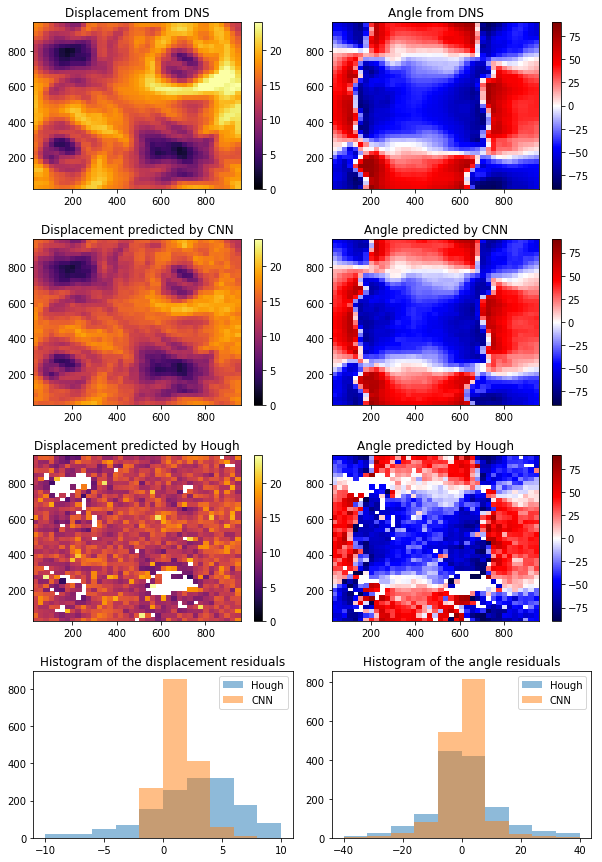

In [46]:
meanDisplacementCNN = np.mean(displacementcnn, axis=0)
meanAngleCNN = np.mean(anglecnn, axis=0)

errorDisplacementCNN = displacementdns - meanDisplacementCNN
errorAngleCNN = angledns - meanAngleCNN

errorDisplacementHough = displacementdns - displacementHough
errorAngleHough = angledns - angleHough

figure(figsize=(10,15))
subplot(4,2,1)
title('Displacement from DNS')
pdispdns=pcolormesh(xdns,ydns,displacementdns,vmin=0,vmax=maxDisplacement,cmap='inferno')
colorbar(pdispdns)
#axis('scaled')

subplot(4,2,2)
title('Angle from DNS')
pangdns=pcolormesh(xdns,ydns,angledns,vmin=-90,vmax=90, cmap='seismic')
colorbar(pangdns)
#axis('scaled')

subplot(4,2,3)
title('Displacement predicted by CNN')
pdispcnn=pcolormesh(xdns,ydns,meanDisplacementCNN,vmin=0,vmax=maxDisplacement,cmap='inferno')
colorbar(pdispcnn)
#axis('scaled')

subplot(4,2,4)
title('Angle predicted by CNN')
panglecnn=pcolormesh(xdns,ydns,meanAngleCNN,vmin=-90,vmax=90, cmap='seismic')
colorbar(panglecnn)
#axis('scaled')

subplot(4,2,5)
title('Displacement predicted by Hough')
pdispcnn=pcolormesh(xdns,ydns,displacementHough,vmin=0,vmax=maxDisplacement,cmap='inferno')
colorbar(pdispcnn)
#axis('scaled')

subplot(4,2,6)
title('Angle predicted by Hough')
panglecnn=pcolormesh(xdns,ydns,angleHough,vmin=-90,vmax=90, cmap='seismic')
colorbar(panglecnn)
#axis('scaled')

subplot(4,2,7)
title('Histogram of the displacement residuals')
hist(np.array(errorDisplacementHough).flatten(), range=(-10,10), density=False, label = 'Hough', alpha=0.5)
hist(np.array(errorDisplacementCNN).flatten(), range=(-10,10), density=False, label = 'CNN', alpha=0.5)
legend(loc='upper right')

subplot(4,2,8)
title('Histogram of the angle residuals')
hist(np.array(errorAngleHough).flatten(), range=(-40,40), density=False, label = 'Hough', alpha=0.5)
hist(np.array(errorAngleCNN).flatten(), range=(-40,40), density=False, label = 'CNN', alpha=0.5)
legend(loc='upper right')

subplots_adjust(hspace=0.3, wspace = 0.15)
savefig('paper/figs/figure6.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)

## Compare the DNS-raw streaks image with CNN recovered streaks

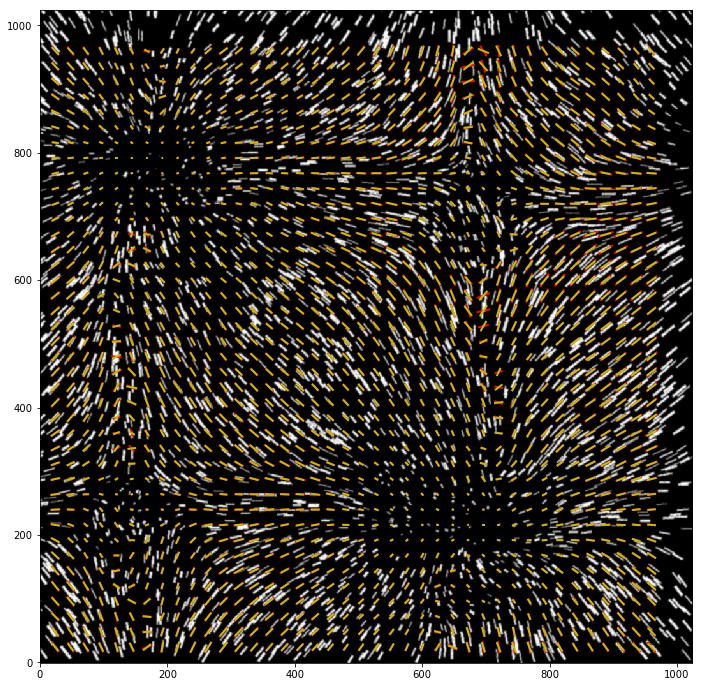

In [40]:
plotdns=True
plotcnn=True
showimage=True

fig=figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)
if showimage==True:
    imshow((myImages[iImage,0,:,:]), origin='lower')

# Streaks from DNS
if plotdns==True:
    xminus = xdns.flatten() - np.cos( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.
    xplus = xdns.flatten() + np.cos( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.

    yminus = ydns.flatten() - np.sin( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.
    yplus = ydns.flatten() + np.sin( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.

    xydns = np.array(([xminus, yminus], [xplus, yplus]));

    for i in range(0,xydns.shape[2]):
        linedns = patches.Polygon(xydns[:,:,i], color = 'r', linewidth = 2)
        ax.add_patch(linedns)
    
# Streaks from CNN
if plotcnn==True:
    x0 = xcnn.flatten() - np.cos( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.
    x1 = xcnn.flatten() + np.cos( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.

    y0 = ycnn.flatten() - np.sin( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.
    y1 = ycnn.flatten() + np.sin( np.mean(anglecnn,axis=0).flatten() * np.pi / 180) \
    * np.mean(displacementcnn,axis=0).flatten() / 2.

    xycnn = np.array(([x0, y0], [x1, y1]));

    for i in range(0,xycnn.shape[2]):
        line = patches.Polygon(xycnn[:,:,i], color = 'y', linewidth = 2)
        ax.add_patch(line)

savefig('paper/figs/figure7.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)
show()

Generate image for the graphical abstract

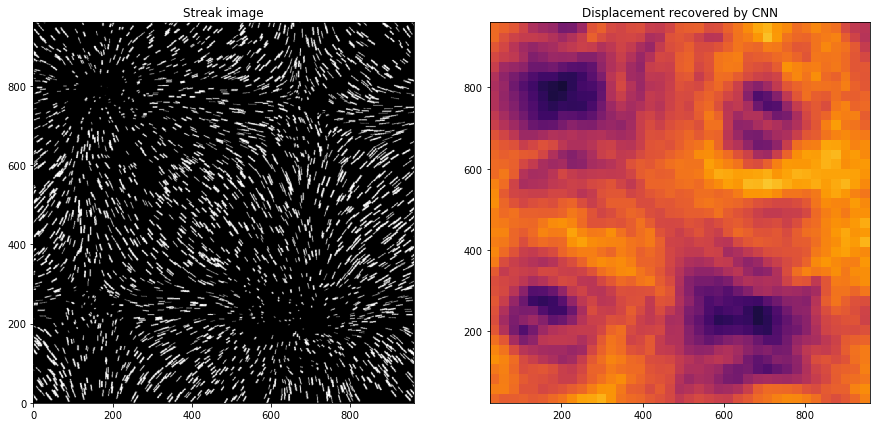

In [39]:
fig = figure(figsize=(15,7))
ax =fig.add_subplot(1,2,1)
imshow((myImages[iImage,0,:,:]), origin='lower')
ax.set_xlim(0, 960)
ax.set_ylim(0, 960)
title('Streak image')

ax = fig.add_subplot(1,2,2)

title('Displacement recovered by CNN')
pcolormesh(xdns,ydns,meanDisplacementCNN,vmin=0,vmax=maxDisplacement,cmap='inferno')

savefig('paper/graphical_abstract.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)
show()